 <p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [6]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [13]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

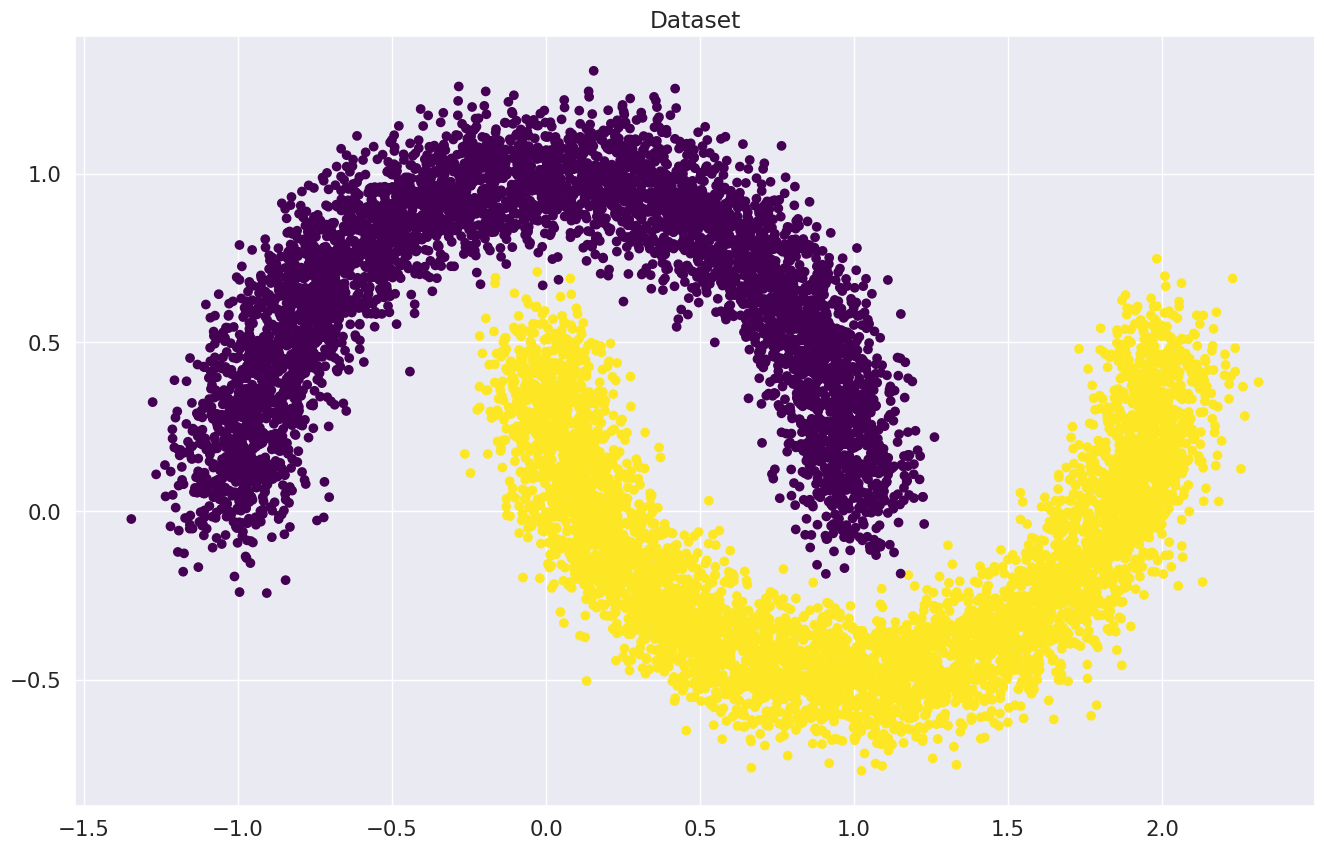

In [14]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [16]:
print(torch.from_numpy(X_train))

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]], dtype=torch.float64)


In [17]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [18]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn([in_features, out_features]))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn([out_features, 1]))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [13]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
print(len(list(linear_regression.parameters())))
summary(linear_regression)

2


Layer (type:depth-idx)                   Param #
LinearRegression                         3
Total params: 3
Trainable params: 3
Non-trainable params: 0

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch).view(-1) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.7578125
Iteration: 100
Batch accuracy: 0.7890625
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 696

### Визуализируем результаты

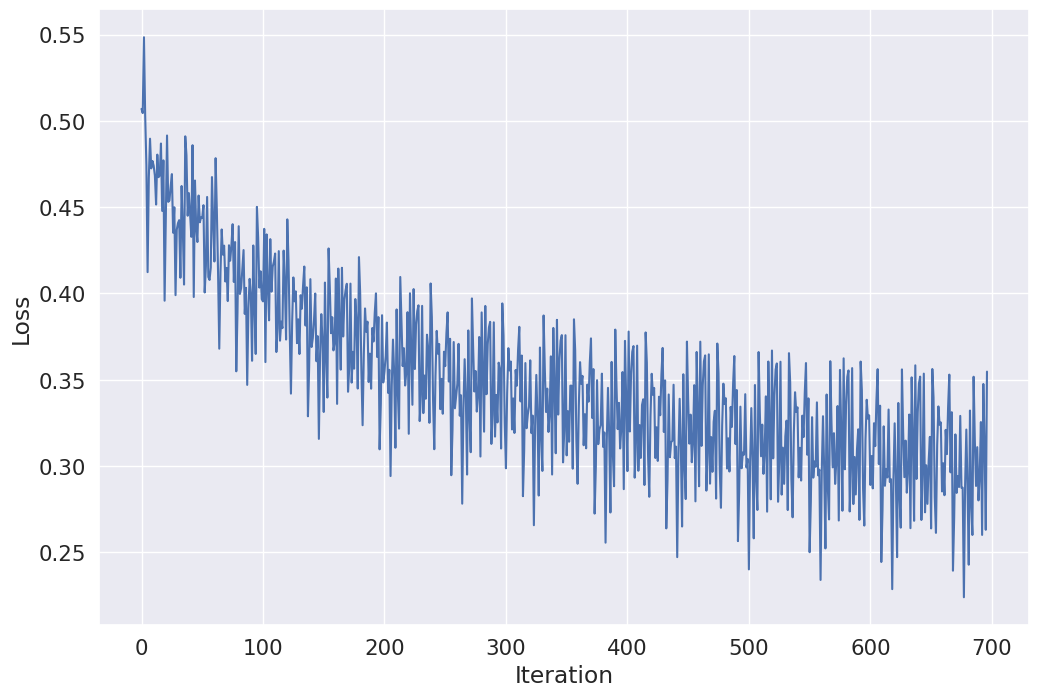

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

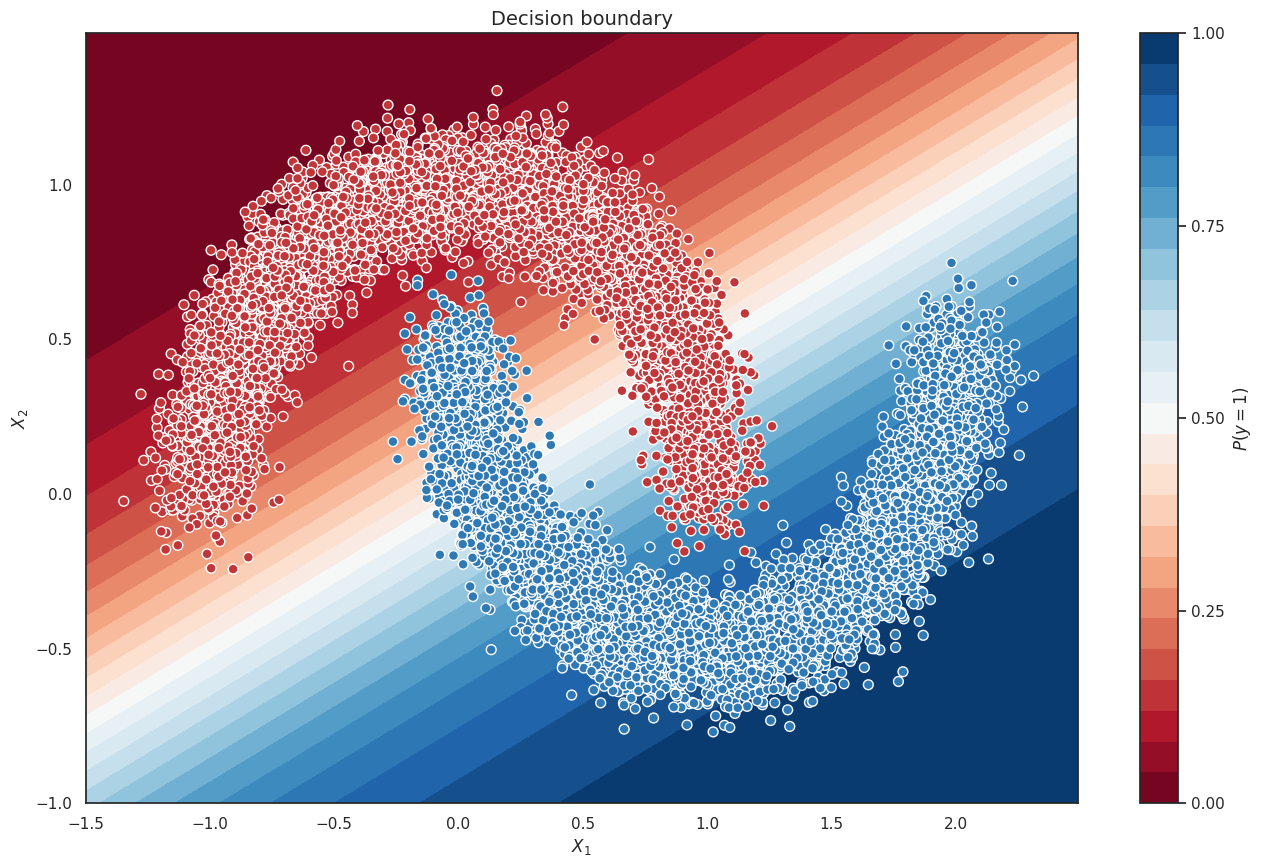

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch) #YOUR CODE. Compute predictions
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = predict(val_dataloader, linear_regression)
print(y_pred.shape)
print(y_val_t.shape)
y_true = y_val_t
accuracy_score(y_true, y_pred)

(2500,)
torch.Size([2500])


0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [21]:
import os
from torchvision.datasets import MNIST

from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 1, 28, 28])

In [63]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10),
    #YOUR CODE. Add layers to your sequential class
)

In [62]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
device = "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [30]:
max_epochs = 10
# accuracy = {"train": [], "valid": []}
accuracy = []
model.to(device)

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum().item() # <--------------- вычисляем количество правильных предсказаний
            all = y_batch.size(0)
            epoch_correct += correct
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #     loss.backward()
            #     optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy.append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.93675
Loader: valid. Accuracy: 0.9403
Epoch: 2
Loader: train. Accuracy: 0.9542833333333334
Loader: valid. Accuracy: 0.9473
Epoch: 3
Loader: train. Accuracy: 0.9635333333333334
Loader: valid. Accuracy: 0.9605
Epoch: 4
Loader: train. Accuracy: 0.9690833333333333
Loader: valid. Accuracy: 0.9671
Epoch: 5
Loader: train. Accuracy: 0.9724
Loader: valid. Accuracy: 0.9699
Epoch: 6
Loader: train. Accuracy: 0.9744
Loader: valid. Accuracy: 0.9726
Epoch: 7
Loader: train. Accuracy: 0.9763666666666667
Loader: valid. Accuracy: 0.9717
Epoch: 8
Loader: train. Accuracy: 0.9792
Loader: valid. Accuracy: 0.9739
Epoch: 9
Loader: train. Accuracy: 0.9802666666666666
Loader: valid. Accuracy: 0.973
Epoch: 10
Loader: train. Accuracy: 0.9818333333333333
Loader: valid. Accuracy: 0.9712


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [118]:
accuracy_all = {}

In [119]:
def test_activation_function(activation):
    if activation == "plain":
        model = nn.Sequential(
            nn.Flatten(),                                                                                                               
            nn.Linear(28*28, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 10),                             
            #YOUR CODE. Add layers to your sequential class
        )
    else:
        model = nn.Sequential(
            nn.Flatten(),                                                                                                               
            nn.Linear(28*28, 128),
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 10),                             
            #YOUR CODE. Add layers to your sequential class
        )
         
    model.to(device)
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    
    accuracy_all[activation] = []
    
    for epoch in range(3):
        
        # # YOUR CODE. Train and validate the model using the specified activation function
        # for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()  # <------------------ переводим модель в режим train
                    optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                    loss.backward()  # <--------------- считаем градиенты
                    optimizer.step()  # <-------------- делаем шаг градиентного спуска
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()  # <------------------ переводим модель в режим eval
                    with torch.no_grad():  # <--------- НЕ считаем градиенты
                        outp = model(x_batch)  # <------------- получаем "логиты" из модели
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item() # <--------------- вычисляем количество правильных предсказаний
                all = y_batch.size(0)
                epoch_correct += correct
                epoch_all += all
                # if k == "train":
                #     loss = criterion(outp, y_batch)
                #     loss.backward()
                #     optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            accuracy = epoch_correct/epoch_all
            print(f"Activation: {activation}, Loader: {k}, Accuracy: {accuracy}")
            # accuracy.append(epoch_correct/epoch_all)
            if k == "valid":
                accuracy_all[activation].append(accuracy)  # Add the validation accuracy to the accuracies list
        
    return accuracy


Записываем только accuracy по valid выборке

In [120]:
plain_accuracy = test_activation_function("plain")
elu_accuracy = test_activation_function(nn.ELU())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Activation: plain, Loader: train, Accuracy: 0.86335
Activation: plain, Loader: valid, Accuracy: 0.8839
Epoch: 2
Activation: plain, Loader: train, Accuracy: 0.8950166666666667
Activation: plain, Loader: valid, Accuracy: 0.8992
Epoch: 3
Activation: plain, Loader: train, Accuracy: 0.9001666666666667
Activation: plain, Loader: valid, Accuracy: 0.8994
Epoch: 1
Activation: ELU(alpha=1.0), Loader: train, Accuracy: 0.87645
Activation: ELU(alpha=1.0), Loader: valid, Accuracy: 0.921
Epoch: 2
Activation: ELU(alpha=1.0), Loader: train, Accuracy: 0.9345
Activation: ELU(alpha=1.0), Loader: valid, Accuracy: 0.9417
Epoch: 3
Activation: ELU(alpha=1.0), Loader: train, Accuracy: 0.9526
Activation: ELU(alpha=1.0), Loader: valid, Accuracy: 0.9522
Epoch: 1
Activation: ReLU(), Loader: train, Accuracy: 0.8755833333333334
Activation: ReLU(), Loader: valid, Accuracy: 0.9199
Epoch: 2
Activation: ReLU(), Loader: train, Accuracy: 0.9383166666666667
Activation: ReLU(), Loader: valid, Accuracy: 0.9407
Epoch

In [121]:
accuracy_all

{'plain': [0.8839, 0.8992, 0.8994],
 ELU(alpha=1.0): [0.921, 0.9417, 0.9522],
 ReLU(): [0.9199, 0.9407, 0.9494],
 LeakyReLU(negative_slope=0.01): [0.928, 0.9474, 0.9511]}

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

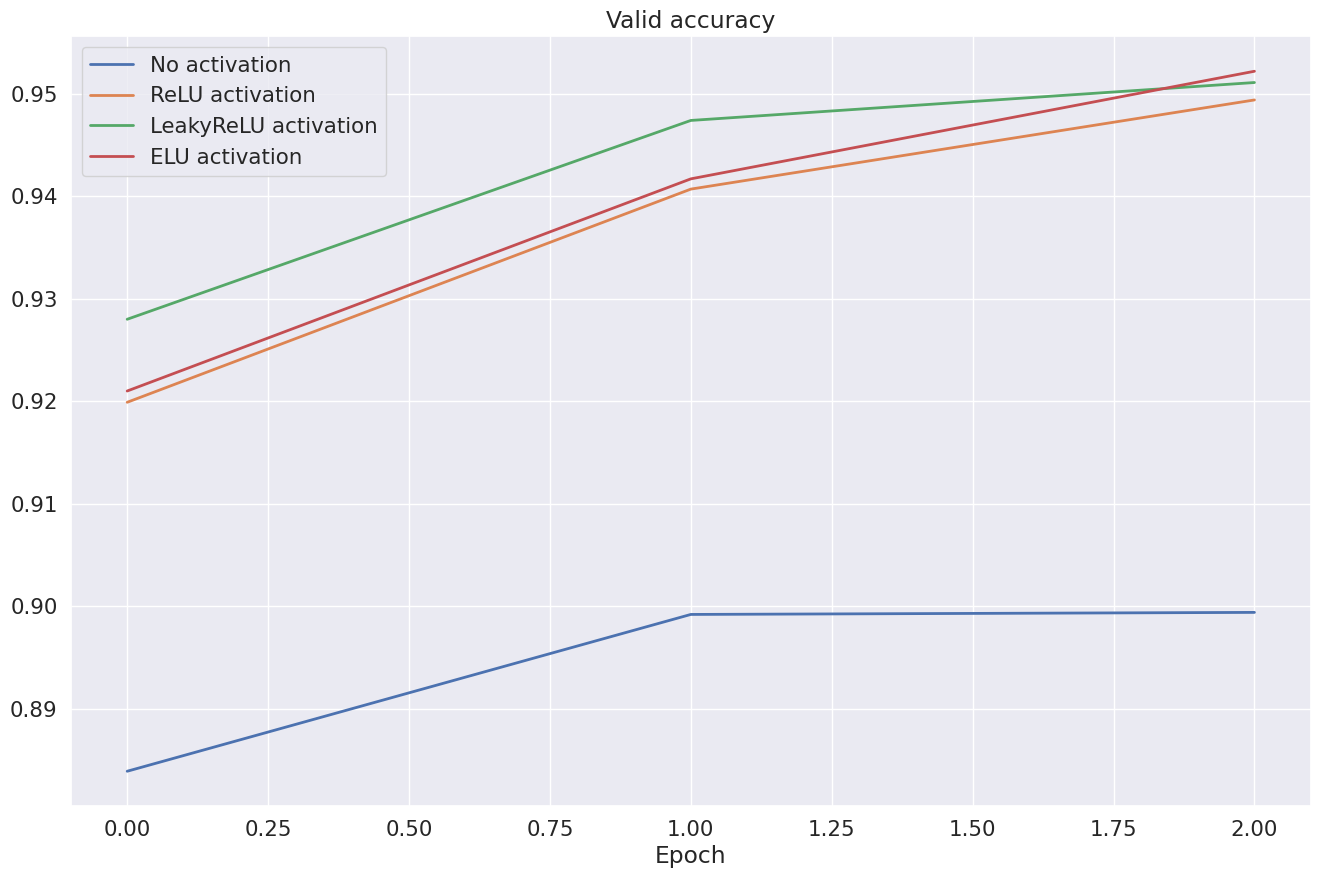

In [124]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(3), accuracy_all["plain"], label="No activation", linewidth=2)
plt.plot(range(3), list(accuracy_all.values())[2], label="ReLU activation", linewidth=2)
plt.plot(range(3), list(accuracy_all.values())[3], label="LeakyReLU activation", linewidth=2)
plt.plot(range(3), list(accuracy_all.values())[1], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [1]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-19 15:42:38--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    in 0,08s   

2023-10-19 15:42:38 (583 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



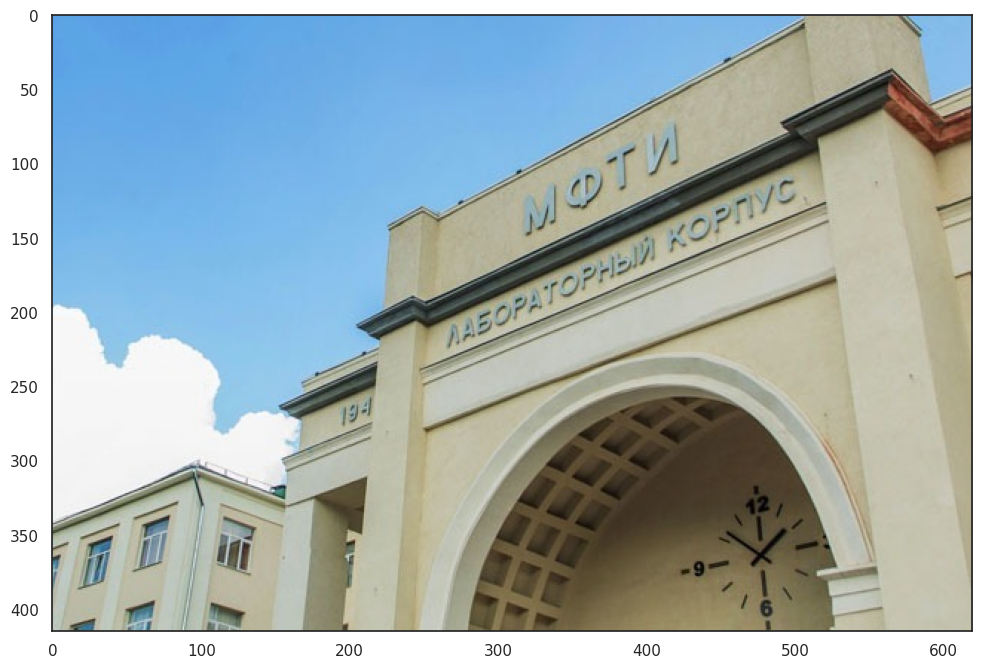

In [5]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [7]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


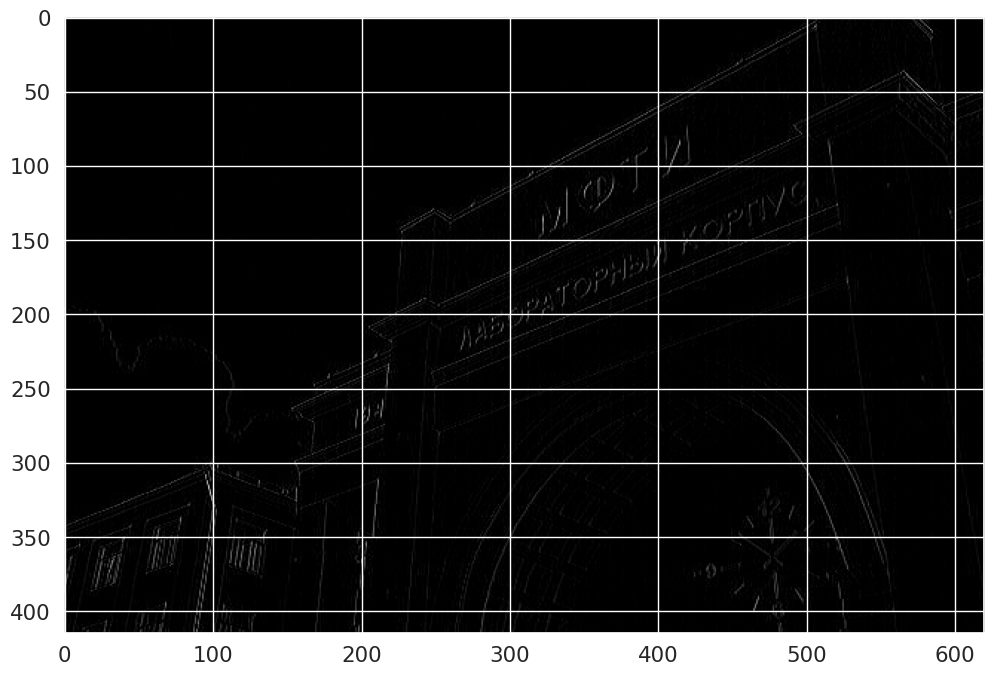

In [8]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е, 2-Д, 3-А, 4-В, 5-Б, 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [41]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.norm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
        self.norm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2) #YOUR CODE
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #YOUR CODE
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.conv1(x) #YOUR CODE. Apply layers created in __init__.
        x = nn.functional.relu(self.norm1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(self.norm2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [42]:
device = "cpu"

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

Epoch 1, Train Loss: 0.08439455288988568, Test Loss: 0.09334587152712813
Test Accuracy: 0.97
Epoch 2, Train Loss: 0.06629022424640968, Test Loss: 0.07822989566285529
Test Accuracy: 0.9734
Epoch 3, Train Loss: 0.05614078127257059, Test Loss: 0.07672261853790414
Test Accuracy: 0.9747
Epoch 4, Train Loss: 0.05122496094703595, Test Loss: 0.0691970782550188
Test Accuracy: 0.9783
Epoch 5, Train Loss: 0.04687119549217779, Test Loss: 0.05521071004802217
Test Accuracy: 0.9813


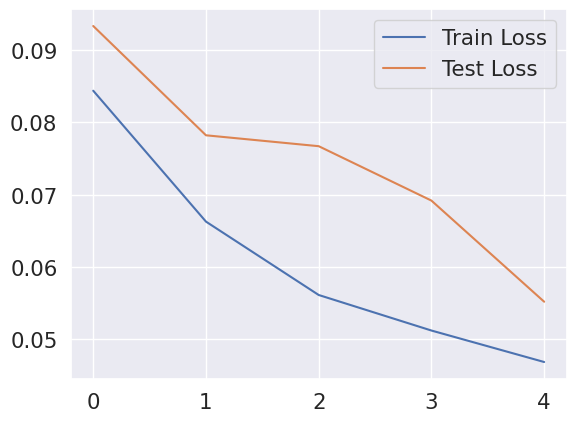

In [44]:
from sklearn.metrics import accuracy_score

# <YOUR CODE>
train_losses = []
test_losses = []
accuracy = []
max_epochs = 5

for epoch in range(max_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Обучение на train_loader
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация на val_loader
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            images = images.to(device)

            max_values, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.detach().cpu())
            y_pred.extend(predicted.detach().cpu())

    train_losses.append(train_loss/len(train_dataloader))
    test_losses.append(test_loss/len(valid_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')
    acc = accuracy_score(y_true, y_pred)
    accuracy.append(acc)
    print(f'Test Accuracy: {acc}')


plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

LeNet самый производительный


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98